VGG16 (D - 16 weight layer)를 구현 후 Cifar10 데이터셋에서 Classification 수행 <br>

![](https://velog.velcdn.com/images/changh2_00/post/2fec6cec-1c79-4003-b8c5-909d1f4ce62c/image.png)

### 블록 정의

In [34]:
import torch
import torch.nn as nn

from tqdm import trange

import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# ──── 1. VGG 블록 정의 ────────────────────────────────────────
def conv_2_block(in_dim, out_dim):
    return nn.Sequential(
        nn.Conv2d(in_dim, out_dim, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_dim, out_dim, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

def conv_3_block(in_dim, out_dim):
    return nn.Sequential(
        nn.Conv2d(in_dim, out_dim, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_dim, out_dim, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_dim, out_dim, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

### VGG16 정의

In [35]:
class VGG16_CIFAR(nn.Module):
    def __init__(self, base_dim=64, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            conv_2_block(3, base_dim),               # 32→16
            conv_2_block(base_dim, base_dim*2),      # 16→8
            conv_3_block(base_dim*2, base_dim*4),    # 8→4
            conv_3_block(base_dim*4, base_dim*8),    # 4→2
            conv_3_block(base_dim*8, base_dim*8),    # 2→1
        )
        # CIFAR10: 마지막 풀링 후 feature map 1×1, 채널 base_dim*8
        self.classifier = nn.Sequential(
            nn.Linear(base_dim*8*1*1, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 1000),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1000, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)


### Load Cifar10 dataset

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print(f"GPU is available. Using device: {device}")
else:
    print("GPU not available. Using CPU.")
    
batch_size   = 100
learning_rate= 0.0002
num_epochs   = 10

# CIFAR-10 전처리: ToTensor + 정규화
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914,0.4822,0.4465),
                         (0.2470,0.2435,0.2616))
])

train_dataset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True,
    transform=transform
)
test_dataset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True,
    transform=transform
)

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=4
)
test_loader  = DataLoader(
    test_dataset,  batch_size=batch_size, shuffle=False, num_workers=4
)

GPU is available. Using device: cuda
Files already downloaded and verified
Files already downloaded and verified


### train 데이터셋 시각화 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.49473685..1.555192].


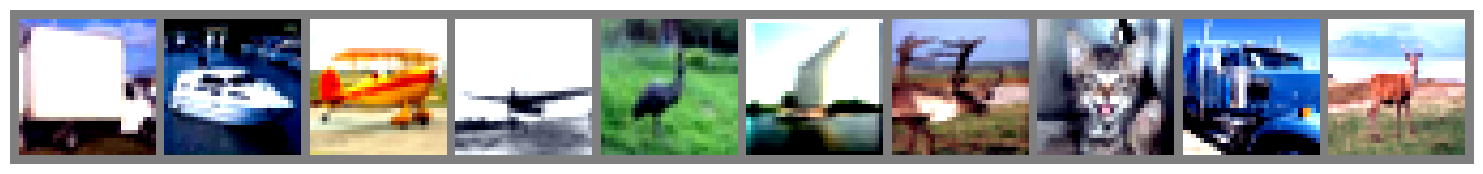

Labels:
  truck    ship   plane   plane    bird    ship    deer     cat   truck    deer


In [42]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# 이미지를 보여주는 함수 (가로 일렬 시각화)
def imshow_horizontal(img, title=None):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(len(img[0]) * 2, 2))  # 이미지 수에 따라 가로 크기 자동 조정
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

# 데이터 로더에서 이미지 가져오기
dataiter = iter(train_loader)
images, labels = next(dataiter)

# 사용할 이미지 수 설정 (예: 10장만 보기)
num_images = 10
images = images[:num_images]
labels = labels[:num_images]

# 가로 일렬로 make_grid 구성
grid = torchvision.utils.make_grid(images, nrow=num_images)
imshow_horizontal(grid)

# 레이블 출력
print('Labels:')
print(' '.join('%7s' % classes[labels[j]] for j in range(num_images)))


### model, loss, optimizer 준비

In [37]:
model     = VGG16_CIFAR(base_dim=64, num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

### 학습

  1%|          | 1/100 [00:36<1:00:35, 36.72s/it]

tensor(1.7905, device='cuda:0', grad_fn=<NllLossBackward0>)


 11%|█         | 11/100 [06:27<52:23, 35.32s/it] 

tensor(0.3021, device='cuda:0', grad_fn=<NllLossBackward0>)


 21%|██        | 21/100 [12:17<45:59, 34.93s/it]

tensor(0.2289, device='cuda:0', grad_fn=<NllLossBackward0>)


 31%|███       | 31/100 [18:00<39:28, 34.32s/it]

tensor(0.0456, device='cuda:0', grad_fn=<NllLossBackward0>)


 41%|████      | 41/100 [23:30<32:24, 32.95s/it]

tensor(0.0210, device='cuda:0', grad_fn=<NllLossBackward0>)


 51%|█████     | 51/100 [29:11<28:06, 34.42s/it]

tensor(0.0017, device='cuda:0', grad_fn=<NllLossBackward0>)


 61%|██████    | 61/100 [34:57<22:23, 34.46s/it]

tensor(0.0130, device='cuda:0', grad_fn=<NllLossBackward0>)


 71%|███████   | 71/100 [40:47<16:46, 34.69s/it]

tensor(0.0203, device='cuda:0', grad_fn=<NllLossBackward0>)


 81%|████████  | 81/100 [46:29<10:49, 34.19s/it]

tensor(0.0066, device='cuda:0', grad_fn=<NllLossBackward0>)


 91%|█████████ | 91/100 [52:15<05:08, 34.31s/it]

tensor(0.0020, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 100/100 [57:19<00:00, 34.40s/it]
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x000001C4EC242B90>
Traceback (most recent call last):
  File "c:\Users\user1\miniconda3\lib\site-packages\torch\utils\data\dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "c:\Users\user1\miniconda3\lib\site-packages\torch\utils\data\dataloader.py", line 1437, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


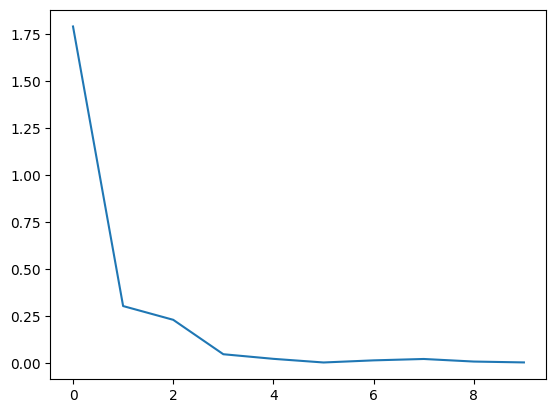

In [ ]:
loss_arr = []
for i in trange(num_epoch):
    for j,[image,label] in enumerate(train_loader):
        x = image.to(device)
        y_= label.to(device)
        
        optimizer.zero_grad()
        output = model.forward(x)
        loss = loss_func(output,y_)
        loss.backward()
        optimizer.step()

    if i % 10 ==0:
        print(loss)
        loss_arr.append(loss.cpu().detach().numpy())

# loss 시각화
plt.plot(loss_arr)
plt.show()

### 테스트

In [43]:
# 맞은 개수, 전체 개수를 저장할 변수를 지정합니다.
correct = 0
total = 0

model.eval()

# 인퍼런스 모드를 위해 no_grad 해줍니다.
with torch.no_grad():
    # 테스트로더에서 이미지와 정답을 불러옵니다.
    for image,label in test_loader:
        
        # 두 데이터 모두 장치에 올립니다.
        x = image.to(device)
        y= label.to(device)

        # 모델에 데이터를 넣고 결과값을 얻습니다.
        output = model.forward(x)
        _,output_index = torch.max(output,1)

        
        # 전체 개수 += 라벨의 개수
        total += label.size(0)
        correct += (output_index == y).sum().float()
    
    # 정확도 도출
    print("Accuracy of Test Data: {}%".format(100*correct/total))

Accuracy of Test Data: 82.19999694824219%
